In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/NLP'

/content/drive/MyDrive/Colab Notebooks/NLP


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.4 MB/s 


In [ ]:
import sys
import os
import re
import csv
import codecs

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.layers #import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.metrics import fbeta_score

from keras.metrics import Precision, AUC, Recall
from tensorflow_addons.metrics import F1Score

Import data

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_y = pd.read_csv("data/test_labels.csv")

Data visualisation

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (159571, 8)
test shape :  (153164, 2)


Histogram of comment lengths

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


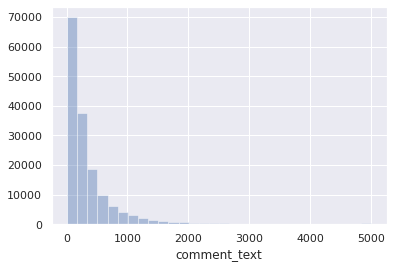

In [ ]:
sns.set(color_codes=True)
sns.distplot(train.comment_text.str.len(), kde=False,bins=30)
plt.show()

Histogram of toxic comments

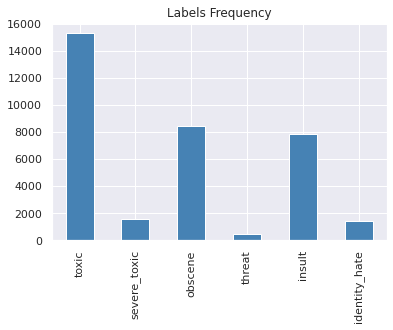

In [ ]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

non_toxic_count = train.shape[0] - label_count.sum()

label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

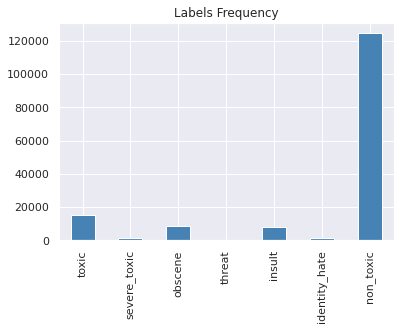

In [ ]:
label_count.at['non_toxic'] = non_toxic_count
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [ ]:
print('non toxic comment : \n',train.comment_text[0])
print('insulting comment : \n',train[train.insult==1].comment_text[6])

non toxic comment : 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
insulting comment : 
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


correlation matrix of toxic labels

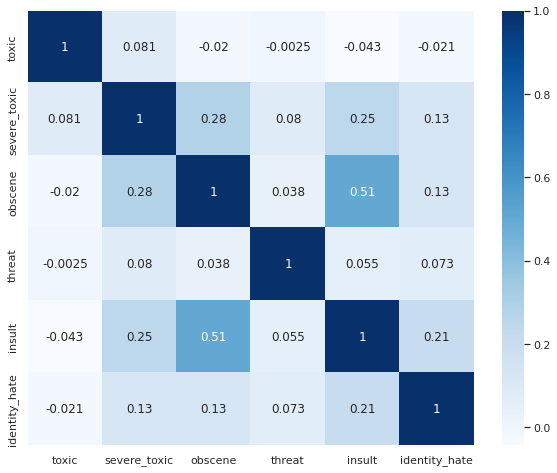

In [ ]:
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:]
train_toxic = temp[rowsums>0]
corr = train_toxic.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()

One hot encoding of the dataset

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(comments_train))
tokenized_train = tokenizer.texts_to_sequences(comments_train)
tokenized_test = tokenizer.texts_to_sequences(comments_test)

In [ ]:
maxlen = 250
padded_train = pad_sequences(tokenized_train, maxlen=maxlen)
padded_test = pad_sequences(tokenized_test, maxlen=maxlen)

Define model
we use AUC, precision and recacll metrics to evaluate

In [ ]:
embed_size = 128

inp = layers.Input(shape=(maxlen, )) #maxlen=200 as defined earlier
x   = layers.Embedding(max_features, embed_size)(inp)
x   = layers.LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   = layers.GlobalMaxPool1D()(x)
x   = layers.Dropout(0.1)(x)
x   = layers.Dense(50, activation="relu")(x)
x   = layers.Dropout(0.1)(x)
x   = layers.Dense(6, activation="sigmoid")(x)


embedded_model = Model(inputs=inp, outputs=x)
embedded_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[Precision(),
                           Recall(),
                           AUC()])


Training

In [ ]:
batch_size = 32
epochs = 2
history = embedded_model.fit(padded_train,
                             y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 76s 15ms/step - loss: 0.0749 - precision_1: 0.7690 - recall: 0.5000 - auc: 0.9514 - val_loss: 0.0499 - val_precision_1: 0.8251 - val_recall: 0.6477 - val_auc: 0.9806
Epoch 2/2
4488/4488 [==============================] - 68s 15ms/step - loss: 0.0458 - precision_1: 0.8253 - recall: 0.6820 - auc: 0.9833 - val_loss: 0.0481 - val_precision_1: 0.8481 - val_recall: 0.6371 - val_auc: 0.9809


In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()